In [1]:
import pybiomart
import pandas as pd 
import anndata 
import scanpy as sc 
import numpy as np 
from metadata import (
    TOTAL_SUM,  
    MIN_GENES, 
    MIN_CELLS, 
    CELL_TYPE_DIR, 
    DRUG_RESPONSE_DIR, 
    CELL_GENERATION_DIR, 
    CELL_LABEL, 
    RESPONSE_LABEL, 
    ORIGINAL_LABEL, 
    UNDEFINED,  
    BASE, 
    MIN_CLUSTER_SIZE, 
    COUNT_DATA_FILE_NAME, 
    SPECIES, 
    SEQUENCING_METHOD, 
    TISSUE, 
    REFERENCE, 
    DRUG, 
) 
import math 
from pyensembl import EnsemblRelease
from scipy.sparse import csr_matrix, vstack 
from scipy.io import mmread
import os 
import warnings 
warnings.filterwarnings("ignore")

Like HumanUnified.ipynb, the data preprocessing is based on [scanpy tutorial](https://scanpy.readthedocs.io/en/stable/tutorials/basics/clustering.html). 

In [2]:
METADATA_NAMES = [
    SPECIES,
    SEQUENCING_METHOD,
    TISSUE,
    REFERENCE,
    CELL_LABEL,
    ORIGINAL_LABEL, 
    DRUG, 
]

def get_target_obs(obs: pd.DataFrame) -> pd.DataFrame:
    metadata_names = set(METADATA_NAMES) 
    target_obs = obs.copy()
    return target_obs.iloc[:, [i for i, column in enumerate(target_obs.columns) if column in metadata_names]]

In [3]:
mouse_dataset = pybiomart.Dataset(
    name="mmusculus_gene_ensembl", 
    host="http://www.ensembl.org", 
    display_name="mouse_dataset"
)
table = mouse_dataset.query(
    attributes=[
        "ensembl_gene_id", 
        "hsapiens_homolog_ensembl_gene", 
        "hsapiens_homolog_associated_gene_name", 
    ]
)
table = table.dropna(subset=["Human gene name"])
table.index = pd.Index(range(len(table)))
ensemble2idx = {table.iloc[i, 0]: i for i in range(len(table))}
mouse_genes = EnsemblRelease(release=100, species="mus_musculus")

In [4]:
def convert_mouse_genes(
    adata: anndata.AnnData, 
    copy: bool = False, 
    is_symbol: bool = True 
) -> anndata.AnnData:

    def find_orthologous_genes(gene_symbol: str) -> str:

        if is_symbol:
            try:
                ensemble_ids = mouse_genes.gene_ids_of_gene_name(gene_symbol)
            except:
                return gene_symbol
        else:
            ensemble_ids = [gene_symbol]

        for ensemble_id in ensemble_ids:
            if ensemble_id in ensemble2idx:
                if len(ensemble_ids) > 1:
                    warnings.warn(
                        f"Multiple ensemble ids found for {gene_symbol}. {ensemble_id} is used to find the orthologous gene.", 
                        UserWarning
                    )
                return table.iloc[ensemble2idx[ensemble_id], 2]
        
        return gene_symbol

    var_names = adata.var_names.values 
    new_var_names = np.vectorize(find_orthologous_genes)(var_names)
    is_changed = new_var_names != var_names
    

    print(f"For {len(var_names)} original genes, {is_changed.sum()} genes are changed to human orthologous genes.")
    if copy:
        adata = adata.copy()
    adata.var.insert(len(adata.var.columns), "_original_symbol", adata.var_names.values)
    adata.var_names = new_var_names
    adata.var[SPECIES] = np.where(is_changed, "human", "mouse")
    adata.var.insert(len(adata.var.columns), "_is_duplicated", adata.var_names.duplicated(keep="first"))
    
    return adata

## Ma-2020

Download related files from [GSE140203](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE140203). After extracting, place these files in ../data/cell_type_annotation/Ma-2020.

In [5]:
source_dir = os.path.join(CELL_TYPE_DIR, "Ma-2020")

In [6]:
count_r = pd.read_csv(
    os.path.join(
        source_dir, 
        "GSM4156608_skin.late.anagen.rna.counts.txt"
    ), 
    sep='\t', 
    index_col=0
).values.T 
gene = pd.read_csv(
    os.path.join(
        source_dir, 
        "GSM4156608_skin.late.anagen.rna.counts.txt" 
    ), 
    sep='\t', 
    usecols=["gene"]
)["gene"].values
barcode_r = pd.read_csv(
    os.path.join(
        source_dir, 
        "GSM4156608_skin.late.anagen.rna.counts.txt"
    ), 
    sep='\t'
).columns[1: ]
barcode_r = [bc.replace(',', '.') for bc in barcode_r]

In [7]:
count_r = csr_matrix(count_r)
adata = anndata.AnnData(
    count_r, 
    obs=pd.DataFrame(index=barcode_r), 
    var=pd.DataFrame(index=gene)
)

In [8]:
barcode_a = pd.read_csv(
    os.path.join(
        source_dir, 
        "GSM4156597_skin.late.anagen.barcodes.txt"
    ), 
    header=None
)[0].values 

In [9]:
match_ = adata.obs_names.isin(barcode_a)
adata = adata[match_].copy()

In [10]:
annotation = pd.read_csv(
    os.path.join(
        source_dir, 
        "GSM4156597_skin_celltype.txt"
    ), 
    sep='\t'
).set_index("rna.bc")

In [11]:
adata.obs[CELL_LABEL] = annotation.loc[adata.obs_names, "celltype"].values
adata.obs_names = [f"{cell}_RNA" for cell in adata.obs_names]
adata.obs["domain"] = "scRNA-seq"

In [12]:
adata.obs[ORIGINAL_LABEL] = adata.obs[CELL_LABEL]
label_counts = adata.obs[ORIGINAL_LABEL].value_counts()
label_counts

annotation
Basal                        7787
Infundibulum                 4139
TAC-1                        3370
Spinous                      3146
Mix                          2543
alowCD34+ bulge              1877
ahighCD34+ bulge             1556
Hair Shaft-cuticle.cortex    1166
Dermal Fibroblast            1121
ORS                          1029
TAC-2                        1008
Medulla                       981
Endothelial                   927
Dermal Papilla                766
Isthmus                       689
IRS                           672
K6+ Bulge Companion Layer     514
Dermal Sheath                 398
Granular                      291
Macrophage DC                 263
Melanocyte                    187
Sebaceous Gland               181
Schwann Cell                  163
Name: count, dtype: int64

In [13]:
adata.obs[CELL_LABEL] = adata.obs[ORIGINAL_LABEL].apply(
    lambda cell_type: cell_type if label_counts[cell_type] >= MIN_CLUSTER_SIZE else UNDEFINED
)
label_counts = adata.obs[CELL_LABEL].value_counts()
label_counts

cell_type
Basal                        7787
Infundibulum                 4139
TAC-1                        3370
Spinous                      3146
Mix                          2543
alowCD34+ bulge              1877
ahighCD34+ bulge             1556
Hair Shaft-cuticle.cortex    1166
Dermal Fibroblast            1121
ORS                          1029
TAC-2                        1008
Medulla                       981
Endothelial                   927
Dermal Papilla                766
Isthmus                       689
IRS                           672
K6+ Bulge Companion Layer     514
Dermal Sheath                 398
Granular                      291
Macrophage DC                 263
Melanocyte                    187
Sebaceous Gland               181
Schwann Cell                  163
Name: count, dtype: int64

In [14]:
adata.raw = adata.copy() 
sc.pp.filter_cells(adata, min_genes=MIN_GENES)
sc.pp.filter_genes(adata, min_cells=MIN_CELLS)
adata.var["mt"] = adata.var_names.str.startswith("mt-")
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True
)

... storing 'cell_type' as categorical
... storing 'domain' as categorical
... storing 'annotation' as categorical


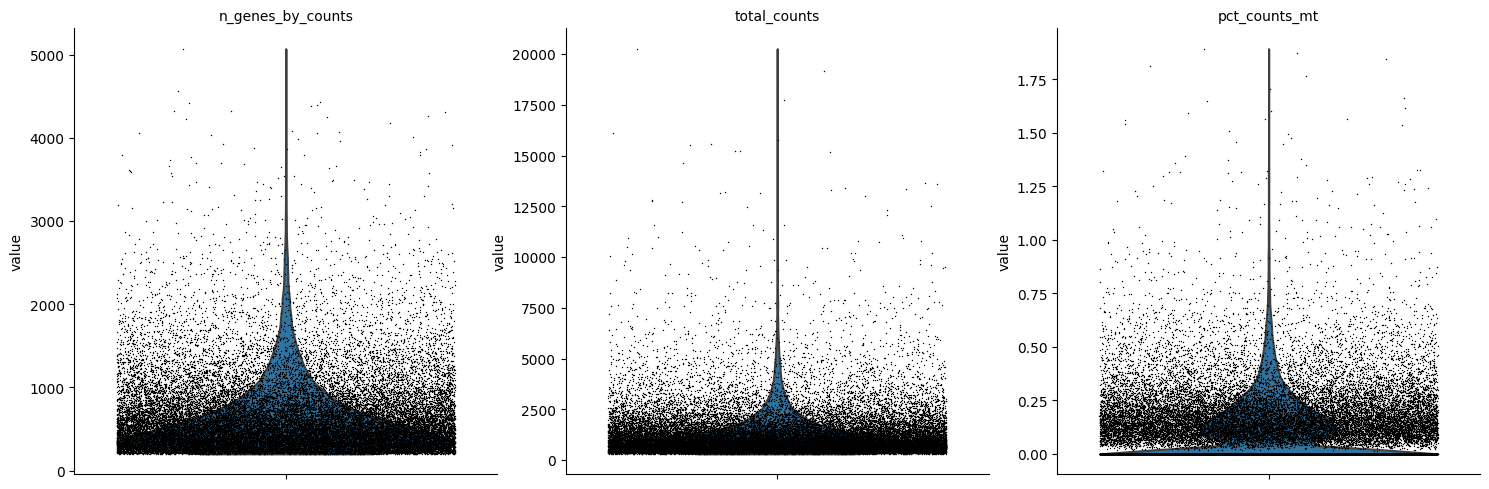

In [15]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

In [16]:
# filter low-quality cell 
adata = adata[adata.obs.n_genes_by_counts < 5000, :]
adata = adata[adata.obs.pct_counts_mt < 0.6, :]
convert_mouse_genes(adata)
# in this case, we filter out duplicated genes directly 
adata = adata[:, ~adata.var["_is_duplicated"]].copy()
print(f"The shape of count matrix: {adata.X.shape}")

For 19103 original genes, 14593 genes are changed to human orthologous genes.
The shape of count matrix: (34135, 18799)


In [17]:
adata_view = adata.copy()
sc.pp.normalize_total(adata_view, target_sum=TOTAL_SUM)
sc.pp.log1p(adata_view, base=BASE)
sc.pp.highly_variable_genes(adata_view, n_top_genes=2000)
sc.pp.pca(adata_view)
sc.pp.neighbors(adata_view)
sc.tl.umap(adata_view)

... storing 'species' as categorical


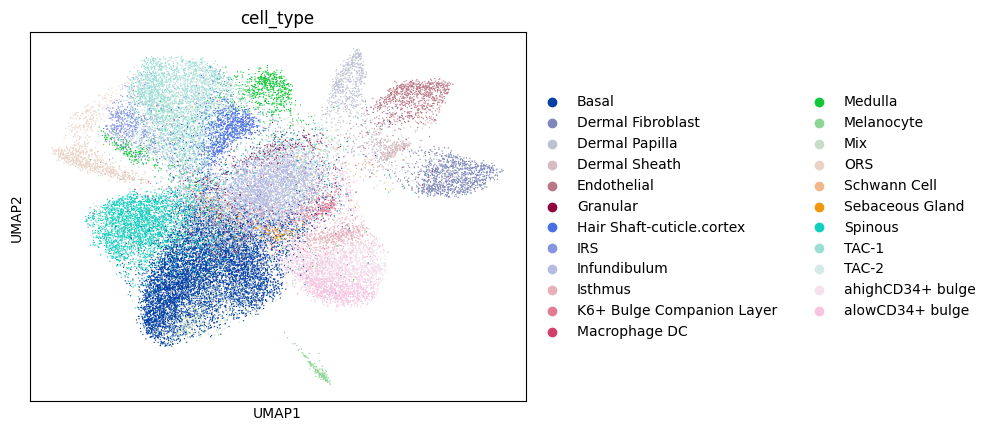

In [18]:
sc.pl.umap(adata_view, color=[CELL_LABEL])

In [19]:
adata.obs[REFERENCE] = (
    "Ma S, Zhang B, LaFave L M, et al. Chromatin potential identified by shared single-cell " 
    "profiling of RNA and chromatin[J]. Cell, 2020, 183(4): 1103-1116. e20." 
)
adata.obs[SPECIES] = "mouse"
adata.obs[TISSUE] = "skin (dorsal)"
adata.obs[SEQUENCING_METHOD] = "SHARE-seq"
adata.obs = get_target_obs(adata.obs)
adata.obs 

,cell_type,annotation,reference,species,tissue,sequencing_method
R1.01.R2.01.R3.06.P1.55_RNA,Dermal Fibroblast,Dermal Fibroblast,"Ma S, Zhang B, LaFave L M, et al. Chromatin po...",mouse,skin (dorsal),SHARE-seq
R1.01.R2.01.R3.36.P1.53_RNA,Dermal Papilla,Dermal Papilla,"Ma S, Zhang B, LaFave L M, et al. Chromatin po...",mouse,skin (dorsal),SHARE-seq
R1.01.R2.01.R3.43.P1.56_RNA,TAC-1,TAC-1,"Ma S, Zhang B, LaFave L M, et al. Chromatin po...",mouse,skin (dorsal),SHARE-seq
R1.01.R2.02.R3.21.P1.56_RNA,IRS,IRS,"Ma S, Zhang B, LaFave L M, et al. Chromatin po...",mouse,skin (dorsal),SHARE-seq
R1.01.R2.02.R3.38.P1.56_RNA,Basal,Basal,"Ma S, Zhang B, LaFave L M, et al. Chromatin po...",mouse,skin (dorsal),SHARE-seq
...,...,...,...,...,...,...
R1.96.R2.92.R3.28.P1.56_RNA,TAC-2,TAC-2,"Ma S, Zhang B, LaFave L M, et al. Chromatin po...",mouse,skin (dorsal),SHARE-seq
R1.96.R2.92.R3.83.P1.54_RNA,Basal,Basal,"Ma S, Zhang B, LaFave L M, et al. Chromatin po...",mouse,skin (dorsal),SHARE-seq
R1.96.R2.92.R3.85.P1.55_RNA,Basal,Basal,"Ma S, Zhang B, LaFave L M, et al. Chromatin po...",mouse,skin (dorsal),SHARE-seq
R1.96.R2.92.R3.86.P1.54_RNA,TAC-1,TAC-1,"Ma S, Zhang B, LaFave L M, et al. Chromatin po...",mouse,skin (dorsal),SHARE-seq


In [20]:
adata.var 

,n_cells,mt,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,_original_symbol,species,_is_duplicated
0610007P14Rik,472,False,472,0.013947,98.642664,485,0610007P14Rik,mouse,False
TRAPPC2B,133,False,133,0.003825,99.617530,133,0610009B22Rik,human,False
0610009L18Rik,53,False,53,0.001524,99.847587,53,0610009L18Rik,mouse,False
0610009O20Rik,732,False,732,0.021568,97.894979,750,0610009O20Rik,mouse,False
SANBR,1461,False,1461,0.045149,95.798585,1570,0610010F05Rik,human,False
...,...,...,...,...,...,...,...,...,...
MT-ND1,5525,True,5525,0.195922,84.111693,6813,mt-Nd1,human,False
MT-ND2,4416,True,4416,0.149278,87.300857,5191,mt-Nd2,human,False
MT-ND4,4359,True,4359,0.145022,87.464773,5043,mt-Nd4,human,False
MT-ND5,9880,True,9880,0.405878,71.587968,14114,mt-Nd5,human,False


In [21]:
adata.write_h5ad(os.path.join(source_dir, COUNT_DATA_FILE_NAME))

... storing 'reference' as categorical
... storing 'species' as categorical
... storing 'tissue' as categorical
... storing 'sequencing_method' as categorical
... storing 'species' as categorical


## Bastidas-Ponce-2019

Download related files from [GSE132188](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE132188). After extracting, place these files in ../data/cell_type_annotation/Bastidas-Ponce-2019.

In [22]:
source_dir = os.path.join(CELL_TYPE_DIR, "Bastidas-Ponce-2019")
adata = anndata.read_h5ad(os.path.join(source_dir, "GSE132188_adata.h5ad.h5"))

In [23]:
adata.obs[CELL_LABEL] = adata.obs["clusters_fig6_broad_final"].apply(
    lambda item: item if item.startswith("Ngn3") else item.split()[-1]
)
adata.obs[ORIGINAL_LABEL] = adata.obs["clusters_fig6_broad_final"]
label_counts = adata.obs[CELL_LABEL].value_counts()
label_counts

cell_type
Acinar          10432
Ductal           6575
Tip              6105
Ngn3 low EP      2616
Ngn3 high EP     2503
Fev+             2058
Trunk            1838
Alpha            1428
Beta             1237
Multipotent      1225
Epsilon           231
Delta             103
Name: count, dtype: int64

In [24]:
adata.var

,n_cells,highly_variable_genes,expression_mean,dispersion
index,,,,
Xkr4,55,False,0.001103,0.862977
Mrpl15,29662,False,0.938518,0.393464
Lypla1,19059,False,0.431010,0.558295
Gm37988,42,False,0.000701,0.733390
Tcea1,19879,False,0.461142,0.552010
...,...,...,...,...
Tmlhe,249,False,0.004602,0.787074
AC168977.1,31,False,0.000601,0.855279
PISD,14189,True,0.337918,0.756587


In [25]:
adata.obs

,day,n_counts,log_counts,n_genes,mt_frac,proliferation,G2M_score,S_score,clusters_fig3_final,clusters_fig3_final_noep,clusters_fig4_final,clusters_fig2_final,clusters_fig6_broad_final,clusters_fig6_fine_final,clusters_fig6_alpha_final,cell_type,annotation
index,,,,,,,,,,,,,,,,,
AAACCTGAGCACCGCT-1-0,12.5,5580.0,8.626944,2180,0.029928,Cycling,-0.252388,0.039791,Trunk,Trunk,Excluded,Trunk,Trunk,Trunk,Trunk,Trunk,Trunk
AAACCTGAGCGCTTAT-1-0,12.5,17605.0,9.775938,3743,0.023630,Cycling,0.179029,0.362894,Tip,Tip,Excluded,Tip,Tip,Tip,Tip,Tip,Tip
AAACCTGAGGGAAACA-1-0,12.5,20882.0,9.946643,4714,0.020879,Cycling,-0.170436,0.220229,Ngn3 low EP,Ductal,Ngn3 low EP,EP,Ngn3 low EP,Ngn3 low EP,Ngn3 low EP,Ngn3 low EP,Ngn3 low EP
AAACCTGAGGTACTCT-1-0,12.5,20594.0,9.932755,4371,0.029523,Cycling,0.056714,0.625414,Prlf. Tip,Prlf. Tip,Excluded,Tip,Prlf. Tip,Tip,Tip,Tip,Prlf. Tip
AAACCTGAGTCACGCC-1-0,12.5,17685.0,9.780472,4115,0.029969,Cycling,-0.204127,0.160393,Tip,Tip,Excluded,Tip,Tip,Tip,Tip,Tip,Tip
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTCAGTTGTTTGG-1-3,15.5,6453.0,8.772301,2471,0.022935,Non-Cycling,-0.208907,-0.045692,Ductal,Ductal,Ductal Bipotent,Ductal,Ductal,Ductal,Ductal,Ductal,Ductal
TTTGTCATCCTGCAGG-1-3,15.5,28195.0,10.246900,4469,0.012378,Cycling,0.599579,0.252814,Mat. Acinar,Mat. Acinar,Excluded,Acinar,Mat. Acinar,Acinar,NaN,Acinar,Mat. Acinar
TTTGTCATCGAATGCT-1-3,15.5,12690.0,9.448569,3614,0.028290,Non-Cycling,-0.206865,-0.240576,Endocrine,Endocrine,Excluded,Endocrine,Alpha,Alpha,secondary Alpha,Alpha,Alpha


In [26]:
sub_adata = []
for sub_dir in [
    "GSM3852752_E12_5_counts", 
    "GSM3852753_E13_5_counts", 
    "GSM3852754_E14_5_counts", 
    "GSM3852755_E15_5_counts"
]:
    cur_dir = os.path.join(source_dir, sub_dir)
    var = pd.read_csv(
        os.path.join(cur_dir, "genes.tsv"), 
        header=None, 
        sep="\t", 
        index_col=0
    )
    var.index.name = "ensemble_id"
    var.columns = ["gene_symbol"]
    obs = pd.read_csv(
        os.path.join(cur_dir, "barcodes.tsv"), 
        header=None, 
        index_col=0
    )
    obs.index.name = "barcode"
    X = csr_matrix(mmread(os.path.join(cur_dir, "matrix.mtx"))).T
    sub_adata.append(anndata.AnnData(X=X, obs=obs, var=var))

In [27]:
raw_adata = sub_adata[0].concatenate(sub_adata[1: ]) 
var_indices = raw_adata.var.gene_symbol.isin(adata.var_names)
obs_indices = raw_adata.obs.index.isin(adata.obs.index)
raw_adata = raw_adata[obs_indices, var_indices].copy()
raw_adata.obs = pd.concat([raw_adata.obs, adata.obs], axis=1, join="inner")

In [28]:
raw_adata.raw = raw_adata.copy() 
sc.pp.filter_cells(raw_adata, min_genes=MIN_GENES)
sc.pp.filter_genes(raw_adata, min_cells=MIN_CELLS)
raw_adata.var["mt"] = raw_adata.var.gene_symbol.str.startswith("mt-")
sc.pp.calculate_qc_metrics(
    raw_adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True
)

... storing 'cell_type' as categorical
... storing 'gene_symbol' as categorical


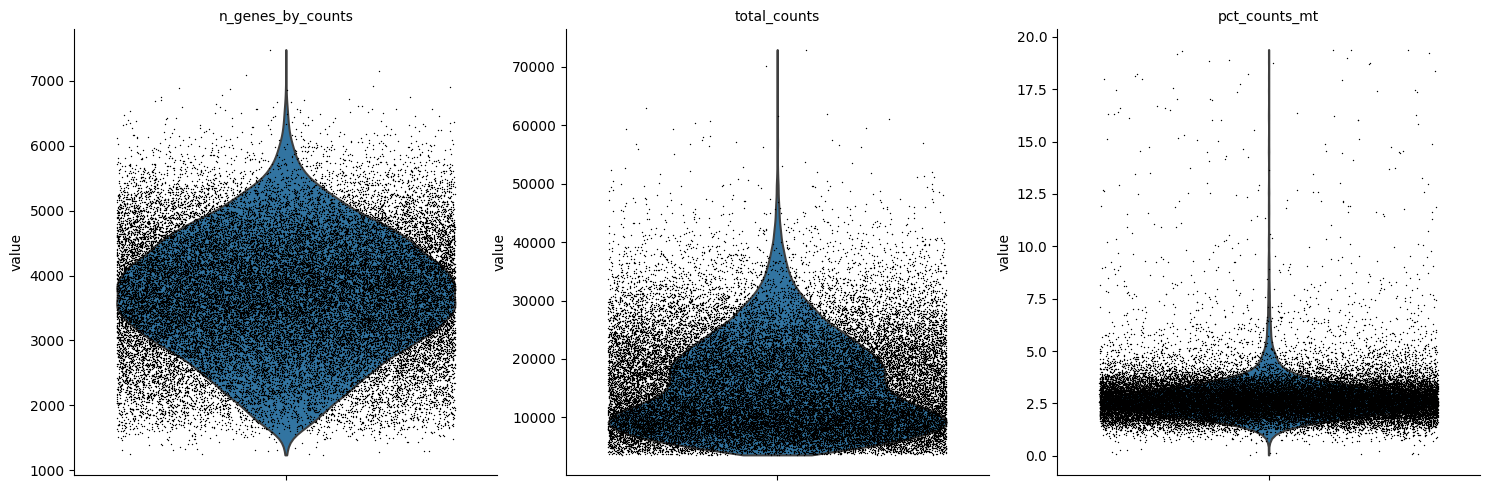

In [29]:
sc.pl.violin(
    raw_adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)


In [30]:
raw_adata = raw_adata[raw_adata.obs.pct_counts_mt < 5.0, :]
convert_mouse_genes(raw_adata, is_symbol=False)
raw_adata.var_names = raw_adata.var_names.map(
    lambda item: raw_adata.var.loc[item, "gene_symbol"] if item.startswith("ENSMUSG") else item
)
raw_adata.var["_is_duplicated"] = raw_adata.var_names.duplicated(keep="first")
# in this case, we filter out duplicated genes directly 
raw_adata = raw_adata[:, ~raw_adata.var["_is_duplicated"]].copy()
print(f"The shape of count matrix: {raw_adata.X.shape}")

For 17241 original genes, 14689 genes are changed to human orthologous genes.
The shape of count matrix: (35481, 16968)


In [31]:
adata_view = raw_adata.copy()
sc.pp.normalize_total(adata_view, target_sum=TOTAL_SUM)
sc.pp.log1p(adata_view, base=BASE)
sc.pp.highly_variable_genes(adata_view, n_top_genes=2000)
sc.pp.pca(adata_view)
sc.pp.neighbors(adata_view)
sc.tl.umap(adata_view)

... storing 'species' as categorical


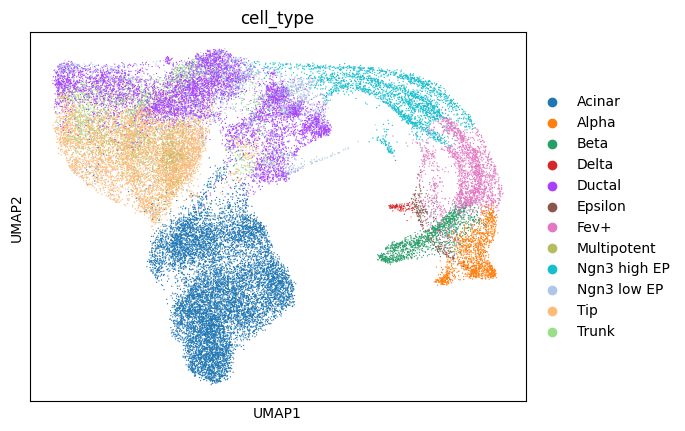

In [32]:
sc.pl.umap(adata_view, color=[CELL_LABEL])

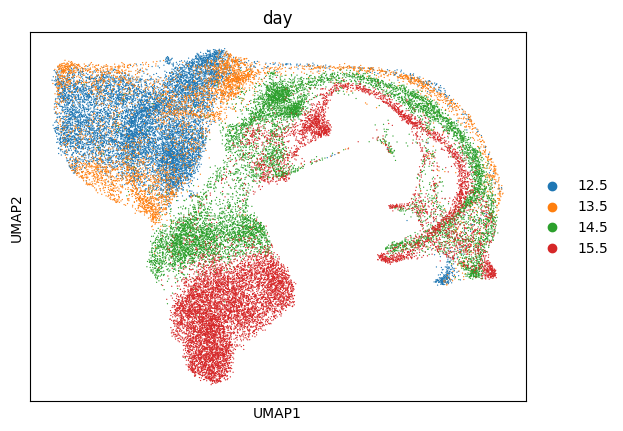

In [33]:
sc.pl.umap(adata_view, color=["day"])

In [34]:
raw_adata.obs[REFERENCE] = (
    "Bastidas-Ponce A, Tritschler S, Dony L, et al. Comprehensive single cell mRNA profiling reveals "
    "a detailed roadmap for pancreatic endocrinogenesis[J]. Development, 2019, 146(12): dev173849." 
)
raw_adata.obs[SPECIES] = "mouse"
raw_adata.obs[TISSUE] = "pancreas"
raw_adata.obs[SEQUENCING_METHOD] = "10xGenomics (Chromium Single Cell 3' Library & Gel Bead Kit v2)"
raw_adata.obs = get_target_obs(raw_adata.obs)
raw_adata.obs 

,cell_type,annotation,reference,species,tissue,sequencing_method
AAACCTGAGCACCGCT-1-0,Trunk,Trunk,"Bastidas-Ponce A, Tritschler S, Dony L, et al....",mouse,pancreas,10xGenomics (Chromium Single Cell 3' Library &...
AAACCTGAGCGCTTAT-1-0,Tip,Tip,"Bastidas-Ponce A, Tritschler S, Dony L, et al....",mouse,pancreas,10xGenomics (Chromium Single Cell 3' Library &...
AAACCTGAGGGAAACA-1-0,Ngn3 low EP,Ngn3 low EP,"Bastidas-Ponce A, Tritschler S, Dony L, et al....",mouse,pancreas,10xGenomics (Chromium Single Cell 3' Library &...
AAACCTGAGGTACTCT-1-0,Tip,Prlf. Tip,"Bastidas-Ponce A, Tritschler S, Dony L, et al....",mouse,pancreas,10xGenomics (Chromium Single Cell 3' Library &...
AAACCTGAGTCACGCC-1-0,Tip,Tip,"Bastidas-Ponce A, Tritschler S, Dony L, et al....",mouse,pancreas,10xGenomics (Chromium Single Cell 3' Library &...
...,...,...,...,...,...,...
TTTGTCAGTTGTTTGG-1-3,Ductal,Ductal,"Bastidas-Ponce A, Tritschler S, Dony L, et al....",mouse,pancreas,10xGenomics (Chromium Single Cell 3' Library &...
TTTGTCATCCTGCAGG-1-3,Acinar,Mat. Acinar,"Bastidas-Ponce A, Tritschler S, Dony L, et al....",mouse,pancreas,10xGenomics (Chromium Single Cell 3' Library &...
TTTGTCATCGAATGCT-1-3,Alpha,Alpha,"Bastidas-Ponce A, Tritschler S, Dony L, et al....",mouse,pancreas,10xGenomics (Chromium Single Cell 3' Library &...
TTTGTCATCTGTTTGT-1-3,Epsilon,Epsilon,"Bastidas-Ponce A, Tritschler S, Dony L, et al....",mouse,pancreas,10xGenomics (Chromium Single Cell 3' Library &...


In [35]:
raw_adata.var

,gene_symbol,n_cells,mt,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,_original_symbol,species,_is_duplicated
XKR4,Xkr4,49,False,49,0.001348,99.865203,49,ENSMUSG00000051951,human,False
MRPL15,Mrpl15,28460,False,28460,2.328712,21.707793,84651,ENSMUSG00000033845,human,False
LYPLA1,Lypla1,18228,False,18228,0.752276,49.855575,27346,ENSMUSG00000025903,human,False
Gm37988,Gm37988,41,False,41,0.001155,99.887211,42,ENSMUSG00000104217,mouse,False
TCEA1,Tcea1,18980,False,18980,0.821793,47.786856,29873,ENSMUSG00000033813,human,False
...,...,...,...,...,...,...,...,...,...,...
Vamp7,Vamp7,17539,False,17539,0.708069,51.750983,25739,ENSMUSG00000051412,mouse,False
Spry3,Spry3,113,False,113,0.003136,99.689142,114,ENSMUSG00000061654,mouse,False
Tmlhe,Tmlhe,234,False,234,0.006520,99.356276,237,ENSMUSG00000079834,mouse,False
DHRSX,DHRSX,16008,False,16008,0.639955,55.962697,23263,ENSMUSG00000063897,mouse,False


In [36]:
raw_adata.write_h5ad(os.path.join(source_dir, COUNT_DATA_FILE_NAME))

... storing 'reference' as categorical
... storing 'species' as categorical
... storing 'tissue' as categorical
... storing 'sequencing_method' as categorical
... storing 'species' as categorical
... storing 'gene_symbol' as categorical


## GSE110894

Download related files from [GSE110894](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE110894). After extracting, place these files in ../data/drug_sensitivity_prediction/GSE110894.

In [37]:
source_dir = os.path.join(DRUG_RESPONSE_DIR, "GSE110894")
count_r = pd.read_csv(
    os.path.join(source_dir, "GSE110894_gene_count.csv"), 
    index_col=0
)
cell_info = pd.read_excel(
    os.path.join(source_dir, "GSE110894_SingleCellInfo.xlsx"), 
    skiprows=3, 
)
cell_info = cell_info[~cell_info["Well position"].isnull()]
cell_info["Well position"] = cell_info["Well position"].apply(
    lambda position: position.split('=', maxsplit=1)[0] 
)

In [38]:
for i in range(1, len(cell_info)):
    if not isinstance(cell_info.iloc[i, 0], str) and math.isnan(cell_info.iloc[i, 0]):
        cell_info.iloc[i, 0] = cell_info.iloc[i - 1, 0]
cell_info.index = pd.Index(cell_info.iloc[:, 0] + '_' + cell_info.iloc[:, 1])
cell_info = cell_info[~cell_info["Well index"].isnull()]
cell_info[RESPONSE_LABEL] = cell_info["Sample name"].apply(
    lambda sample_name: "Resistant" if "RESISTANT" in sample_name else "Sensitive"
)

In [39]:
X = csr_matrix(count_r.values.T)
obs = pd.DataFrame(index=count_r.columns)
var = pd.DataFrame(index=count_r.index)
adata = anndata.AnnData(
    X=X, 
    obs=obs, 
    var=var 
)
adata.obs = adata.obs.join(cell_info) 

In [40]:
adata.obs

,Plate#,Well position,Sample name,Index-Sort condition,Well index,drug_response
RPI1_A3,RPI1,A3,MA9 IBET RESISTANT CELLS,GR+,GGTCTATG,Resistant
RPI1_A4,RPI1,A4,MA9 IBET RESISTANT CELLS,GR+,GTCCGAAT,Resistant
RPI1_A5,RPI1,A5,MA9 IBET RESISTANT CELLS,GR+,TAGTGCGT,Resistant
RPI1_A6,RPI1,A6,MA9 IBET RESISTANT CELLS,GR+,GACTGTAC,Resistant
RPI1_A7,RPI1,A7,MA9 IBET RESISTANT CELLS,GR+,TCCAGTAG,Resistant
...,...,...,...,...,...,...
RPI7_P18,RPI7,P18,MA9 IBET RESISTANT CELLS- WITHDRAWAL,GR-,ACGTGTGT,Resistant
RPI7_P19,RPI7,P19,MA9 IBET RESISTANT CELLS- WITHDRAWAL,GR-,TCAGCGTA,Resistant
RPI7_P20,RPI7,P20,MA9 IBET RESISTANT CELLS- WITHDRAWAL,GR-,AGAAGAGG,Resistant
RPI7_P21,RPI7,P21,EMPTY,EMPTY,TATCCGGA,Sensitive


In [41]:
adata.var 

""
gene_id
ENSMUSG00000110331
ENSMUSG00000006281
ENSMUSG00000040726
ENSMUSG00000024829
ENSMUSG00000029007
...
ENSMUSG00000100418
ENSMUSG00000069925
ENSMUSG00000053687


In [42]:
def convert_gene_id(item): 
    try:
        return mouse_genes.gene_name_of_gene_id(item)
    except:
        return item
    
adata.var["gene_symbol"] = adata.var_names.map(convert_gene_id)

In [43]:
adata.raw = adata.copy() 
sc.pp.filter_cells(adata, min_genes=MIN_GENES)
sc.pp.filter_genes(adata, min_cells=MIN_CELLS)
adata.var["mt"] = adata.var_names.str.startswith("mt-")
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True
)

... storing 'Plate#' as categorical
... storing 'Well position' as categorical
... storing 'Sample name' as categorical
... storing 'Index-Sort condition' as categorical
... storing 'Well index' as categorical
... storing 'drug_response' as categorical
... storing 'gene_symbol' as categorical


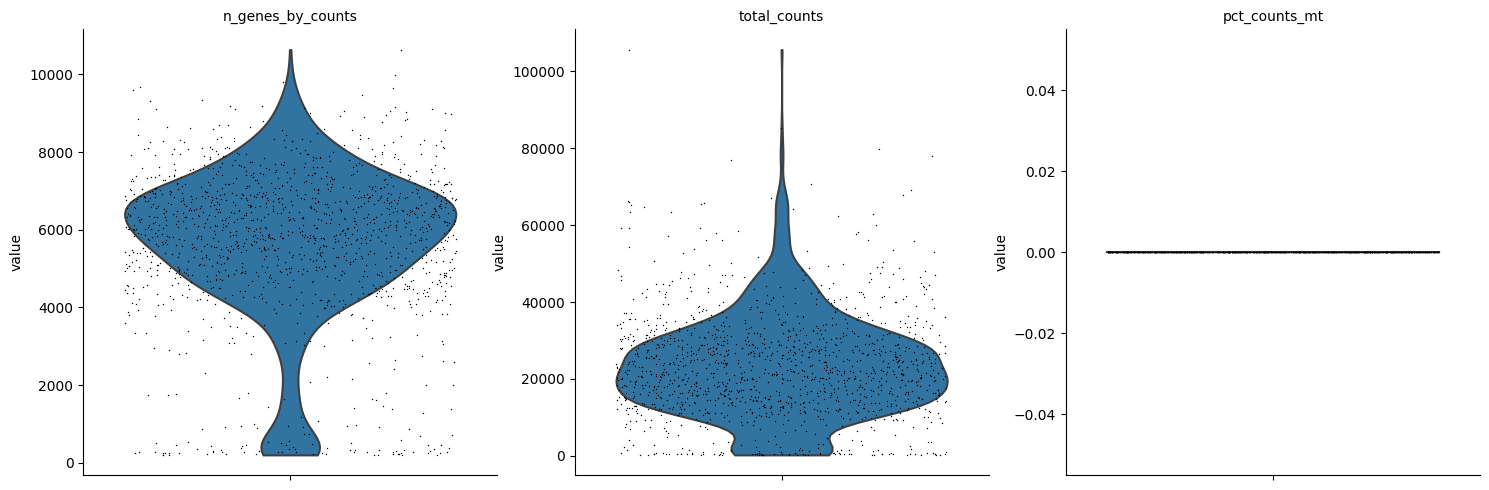

In [44]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

In [45]:
convert_mouse_genes(adata, is_symbol=False)
adata.var_names = adata.var_names.map(
    lambda item: adata.var.loc[item, "gene_symbol"] if item.startswith("ENSMUSG") else item
)
adata.var["_is_duplicated"] = adata.var_names.duplicated(keep="first")
# in this case, we filter out duplicated genes directly 
adata = adata[:, ~adata.var["_is_duplicated"]].copy()
print(f"The shape of count matrix: {adata.X.shape}")

For 18256 original genes, 11017 genes are changed to human orthologous genes.
The shape of count matrix: (1419, 17980)


In [46]:
adata_view = adata.copy()
sc.pp.normalize_total(adata_view, target_sum=TOTAL_SUM)
sc.pp.log1p(adata_view, base=BASE)
sc.pp.highly_variable_genes(adata_view, n_top_genes=2000)
sc.pp.pca(adata_view)
sc.pp.neighbors(adata_view)
sc.tl.umap(adata_view)

... storing 'species' as categorical


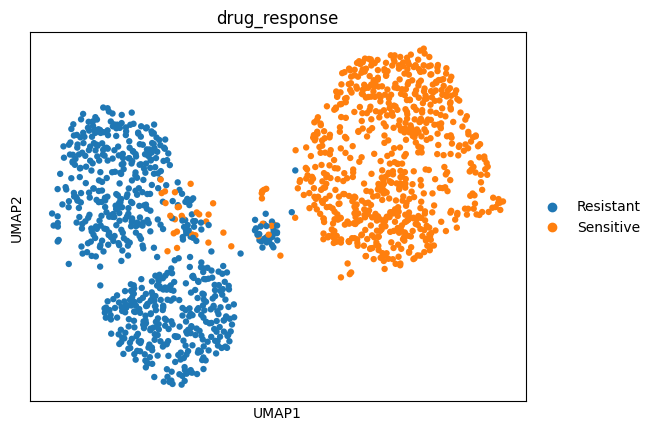

In [47]:
sc.pl.umap(adata_view, color=[RESPONSE_LABEL])

In [48]:
adata.obs[REFERENCE] = (
    "Bell C C, Fennell K A, Chan Y C, et al. Targeting enhancer switching overcomes " 
    "non-genetic drug resistance in acute myeloid leukaemia[J]. Nature communications, 2019, 10(1): 2723."
)
adata.obs[SPECIES] = "mouse"
adata.obs[TISSUE] = "bone marrow"
adata.obs[SEQUENCING_METHOD] = "Cel-Seq2"
adata.obs[DRUG] = "BET inhibitor (I-BET-762)"
adata.obs = get_target_obs(adata.obs)
adata.obs 

,reference,species,tissue,sequencing_method,drug
RPI1_A3,"Bell C C, Fennell K A, Chan Y C, et al. Target...",mouse,bone marrow,Cel-Seq2,BET inhibitor (I-BET-762)
RPI1_A4,"Bell C C, Fennell K A, Chan Y C, et al. Target...",mouse,bone marrow,Cel-Seq2,BET inhibitor (I-BET-762)
RPI1_A5,"Bell C C, Fennell K A, Chan Y C, et al. Target...",mouse,bone marrow,Cel-Seq2,BET inhibitor (I-BET-762)
RPI1_A6,"Bell C C, Fennell K A, Chan Y C, et al. Target...",mouse,bone marrow,Cel-Seq2,BET inhibitor (I-BET-762)
RPI1_A7,"Bell C C, Fennell K A, Chan Y C, et al. Target...",mouse,bone marrow,Cel-Seq2,BET inhibitor (I-BET-762)
...,...,...,...,...,...
RPI7_P18,"Bell C C, Fennell K A, Chan Y C, et al. Target...",mouse,bone marrow,Cel-Seq2,BET inhibitor (I-BET-762)
RPI7_P19,"Bell C C, Fennell K A, Chan Y C, et al. Target...",mouse,bone marrow,Cel-Seq2,BET inhibitor (I-BET-762)
RPI7_P20,"Bell C C, Fennell K A, Chan Y C, et al. Target...",mouse,bone marrow,Cel-Seq2,BET inhibitor (I-BET-762)
RPI7_P21,"Bell C C, Fennell K A, Chan Y C, et al. Target...",mouse,bone marrow,Cel-Seq2,BET inhibitor (I-BET-762)


In [49]:
adata.write_h5ad(os.path.join(source_dir, COUNT_DATA_FILE_NAME))

... storing 'reference' as categorical
... storing 'species' as categorical
... storing 'tissue' as categorical
... storing 'sequencing_method' as categorical
... storing 'drug' as categorical
... storing 'species' as categorical
... storing 'gene_symbol' as categorical


## Mouse-Atlas

Download related files from [GSM4505404](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM4505404). After extracting, place these files in ../data/conditional_pseudo_cell_generation/Mouse-Atlas.

In [50]:
source_dir = os.path.join(CELL_GENERATION_DIR, "Mouse-Atlas")
adata = anndata.read_h5ad(
    os.path.join(
        source_dir, 
        "GSM4505404_tabula-muris-senis-droplet-official-raw-obj.h5ad"
    )
)

In [51]:
adata.obs

,age,cell,cell_ontology_class,cell_ontology_id,free_annotation,method,mouse.id,n_genes,sex,subtissue,tissue,tissue_free_annotation
index,,,,,,,,,,,,
AAACCTGCAGGGTACA-1-0-0-0,24m,MACA_24m_M_TONGUE_60_AAACCTGCAGGGTACA,keratinocyte,NA,filiform,droplet,24-M-60,2107.0,male,nan,Tongue,Tongue
AAACCTGCAGTAAGCG-1-0-0-0,24m,MACA_24m_M_TONGUE_60_AAACCTGCAGTAAGCG,keratinocyte,NA,suprabasal,droplet,24-M-60,3481.0,male,nan,Tongue,Tongue
AAACCTGTCATTATCC-1-0-0-0,24m,MACA_24m_M_TONGUE_60_AAACCTGTCATTATCC,keratinocyte,NA,suprabasal,droplet,24-M-60,2599.0,male,nan,Tongue,Tongue
AAACGGGGTACAGTGG-1-0-0-0,24m,MACA_24m_M_TONGUE_60_AAACGGGGTACAGTGG,keratinocyte,NA,suprabasal differentiating,droplet,24-M-60,3468.0,male,nan,Tongue,Tongue
AAACGGGGTCTTCTCG-1-0-0-0,24m,MACA_24m_M_TONGUE_60_AAACGGGGTCTTCTCG,keratinocyte,NA,suprabasal differentiating,droplet,24-M-60,3189.0,male,nan,Tongue,Tongue
...,...,...,...,...,...,...,...,...,...,...,...,...
10X_P8_15_TTTGTCAGTACATGTC-1,3m,10X_P8_15_TTTGTCAGTACATGTC,basal epithelial cell of tracheobronchial tree,CL:0000066,nan,droplet,3-M-7/8,NaN,male,nan,Trachea,Trachea
10X_P8_15_TTTGTCAGTGCGCTTG-1,3m,10X_P8_15_TTTGTCAGTGCGCTTG,mesenchymal progenitor cell,CL:0008019,nan,droplet,3-M-7/8,NaN,male,nan,Trachea,Trachea
10X_P8_15_TTTGTCAGTTGTCGCG-1,3m,10X_P8_15_TTTGTCAGTTGTCGCG,endothelial cell,CL:0000115,nan,droplet,3-M-7/8,NaN,male,nan,Trachea,Trachea


In [52]:
adata.var

,n_cells
index,
Xkr4,147
Rp1,233
Sox17,27289
Mrpl15,95312
Lypla1,86096
...,...
LOC434960,5
LOC380994,32
LOC100041346,19


In [53]:
adata.obs[ORIGINAL_LABEL] = adata.obs["cell_ontology_class"]
label_counts = adata.obs[ORIGINAL_LABEL].value_counts()
adata.obs[CELL_LABEL] = adata.obs[ORIGINAL_LABEL].apply(
    lambda cell_type: cell_type if label_counts[cell_type] >= MIN_CLUSTER_SIZE else UNDEFINED
)

In [54]:
adata.raw = adata.copy() 
sc.pp.filter_cells(adata, min_genes=MIN_GENES)
sc.pp.filter_genes(adata, min_cells=MIN_CELLS)
adata.var["mt"] = adata.var_names.str.startswith("mt-")
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True
)

... storing 'cell_type' as categorical


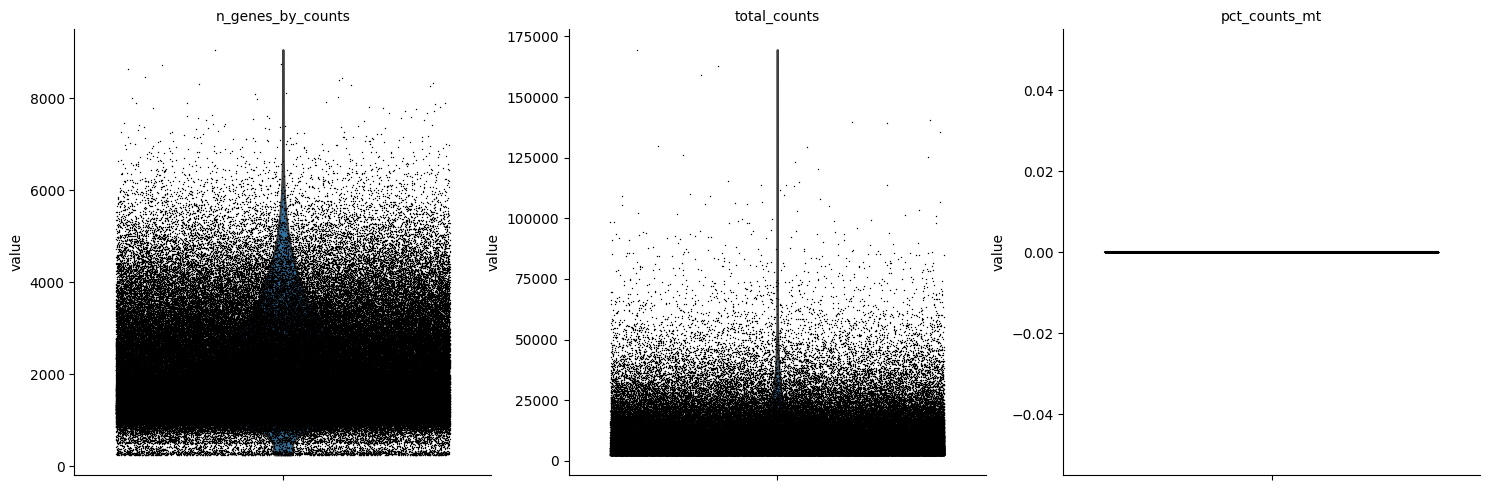

In [55]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

In [56]:
adata = adata[adata.obs[CELL_LABEL] != UNDEFINED, :]
convert_mouse_genes(adata)
# in this case, we filter out duplicated genes directly 
adata = adata[:, ~adata.var["_is_duplicated"]].copy()
print(f"The shape of count matrix: {adata.X.shape}")

For 19465 original genes, 15009 genes are changed to human orthologous genes.
The shape of count matrix: (245365, 19025)


In [57]:
adata.obs.tissue.value_counts()

tissue
Marrow             40220
Spleen             35718
Limb_Muscle        28867
Lung               24521
Kidney             21644
Tongue             20680
Mammary_Gland      12295
Thymus              9275
Bladder             8945
Heart_and_Aorta     8613
Trachea             7976
Liver               7292
Fat                 6777
Pancreas            6201
Skin                4454
Large_Intestine     1887
Name: count, dtype: int64

In [58]:
adata.obs[REFERENCE] = (
    "A single-cell transcriptomic atlas characterizes ageing tissues in the mouse[J]. Nature, 2020, 583(7817): 590-595." 
)
adata.obs[SPECIES] = "mouse"
adata.obs[TISSUE] = adata.obs["tissue"].apply(lambda tissue: tissue.lower())
adata.obs[SEQUENCING_METHOD] = "10xGenomics (GemCode Single-Cell 3' Gel Bead and Library V2 Kit)"
adata.obs = get_target_obs(adata.obs)
adata.obs

,tissue,annotation,cell_type,reference,species,sequencing_method
index,,,,,,
AAACCTGCAGGGTACA-1-0-0-0,tongue,keratinocyte,keratinocyte,A single-cell transcriptomic atlas characteriz...,mouse,10xGenomics (GemCode Single-Cell 3' Gel Bead a...
AAACCTGCAGTAAGCG-1-0-0-0,tongue,keratinocyte,keratinocyte,A single-cell transcriptomic atlas characteriz...,mouse,10xGenomics (GemCode Single-Cell 3' Gel Bead a...
AAACCTGTCATTATCC-1-0-0-0,tongue,keratinocyte,keratinocyte,A single-cell transcriptomic atlas characteriz...,mouse,10xGenomics (GemCode Single-Cell 3' Gel Bead a...
AAACGGGGTACAGTGG-1-0-0-0,tongue,keratinocyte,keratinocyte,A single-cell transcriptomic atlas characteriz...,mouse,10xGenomics (GemCode Single-Cell 3' Gel Bead a...
AAACGGGGTCTTCTCG-1-0-0-0,tongue,keratinocyte,keratinocyte,A single-cell transcriptomic atlas characteriz...,mouse,10xGenomics (GemCode Single-Cell 3' Gel Bead a...
...,...,...,...,...,...,...
10X_P8_15_TTTGTCAGTACATGTC-1,trachea,basal epithelial cell of tracheobronchial tree,basal epithelial cell of tracheobronchial tree,A single-cell transcriptomic atlas characteriz...,mouse,10xGenomics (GemCode Single-Cell 3' Gel Bead a...
10X_P8_15_TTTGTCAGTGCGCTTG-1,trachea,mesenchymal progenitor cell,mesenchymal progenitor cell,A single-cell transcriptomic atlas characteriz...,mouse,10xGenomics (GemCode Single-Cell 3' Gel Bead a...
10X_P8_15_TTTGTCAGTTGTCGCG-1,trachea,endothelial cell,endothelial cell,A single-cell transcriptomic atlas characteriz...,mouse,10xGenomics (GemCode Single-Cell 3' Gel Bead a...


In [59]:
selected_tissues = ["spleen", "lung", "thymus", "bladder", "liver"]
for tissue in selected_tissues:
    current_adata = adata[adata.obs[TISSUE] == tissue].copy() 
    data_dir = os.path.join(CELL_GENERATION_DIR, f"Mouse-Atlas-{tissue.title()}")
    if not os.path.exists(data_dir):
        os.mkdir(os.path.join(CELL_GENERATION_DIR, f"Mouse-Atlas-{tissue.title()}"))
    current_adata.write_h5ad(os.path.join(data_dir, COUNT_DATA_FILE_NAME))
indices = adata.obs[TISSUE].isin(selected_tissues).values

... storing 'reference' as categorical
... storing 'species' as categorical
... storing 'sequencing_method' as categorical
... storing 'species' as categorical
... storing 'reference' as categorical
... storing 'species' as categorical
... storing 'sequencing_method' as categorical
... storing 'species' as categorical
... storing 'reference' as categorical
... storing 'species' as categorical
... storing 'sequencing_method' as categorical
... storing 'species' as categorical
... storing 'reference' as categorical
... storing 'species' as categorical
... storing 'sequencing_method' as categorical
... storing 'species' as categorical
... storing 'reference' as categorical
... storing 'species' as categorical
... storing 'sequencing_method' as categorical
... storing 'species' as categorical


In [60]:
adata_view = adata[indices].copy()
sc.pp.normalize_total(adata_view, target_sum=TOTAL_SUM)
sc.pp.log1p(adata_view, base=BASE)
sc.pp.pca(adata_view)
sc.pp.neighbors(adata_view)
sc.tl.umap(adata_view)

... storing 'reference' as categorical
... storing 'species' as categorical
... storing 'sequencing_method' as categorical


... storing 'species' as categorical


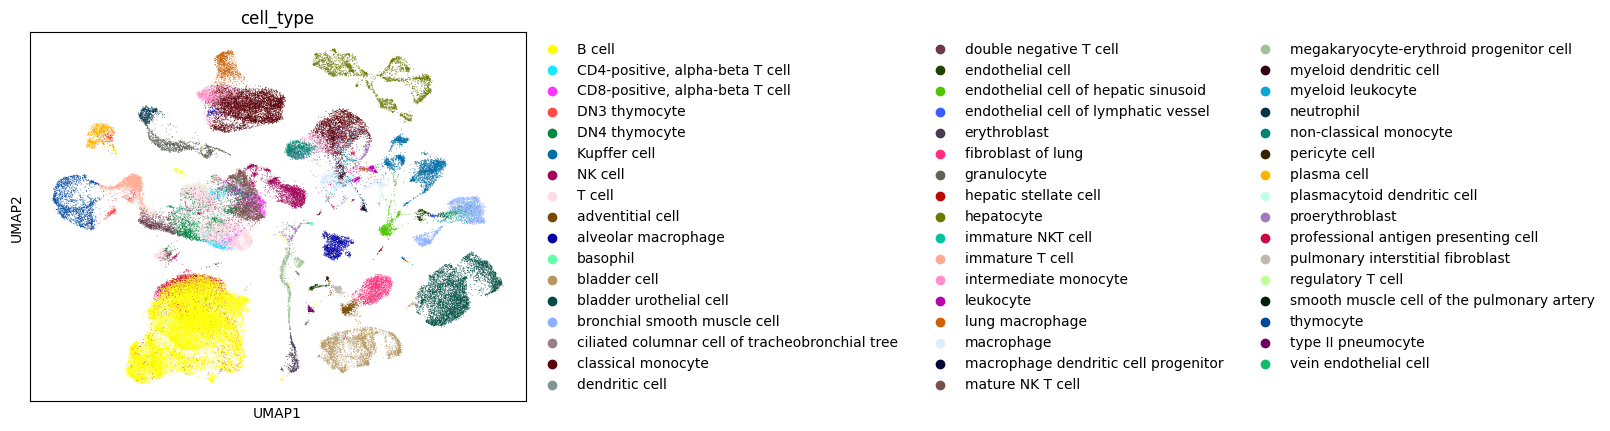

In [61]:
sc.pl.umap(adata_view, color=[CELL_LABEL])

## Tabular-Muris

Download related files from [figshare](https://figshare.com/articles/dataset/Single-cell_RNA-seq_data_from_microfluidic_emulsion_v2_/5968960). After extracting, place these files in ../data/conditional_pseudo_cell_generation/Tabular-Muris.

In [62]:
source_dir = os.path.join(CELL_GENERATION_DIR, "Tabular-Muris")
sub_dir = os.path.join(source_dir, "droplet")
annotation = pd.read_csv(
    os.path.join(source_dir, "annotations_droplet.csv"),
    index_col=0,
    usecols=["cell", "cell_ontology_class", "tissue"], 
)
annotation["cell_ontology_class"] = np.where(
    annotation["cell_ontology_class"].isnull(),
    UNDEFINED,
    annotation["cell_ontology_class"].values 
) 
target_cells = set(annotation.index) 
var = None 
obs = [] 
X = [] 
for sample_dir in os.listdir(sub_dir): 
    prefix = sample_dir.split('-', maxsplit=1)[-1]
    barcodes = pd.read_csv(
        os.path.join(sub_dir, sample_dir, "barcodes.tsv"), 
        sep='\t', 
        index_col=0,
        header=None, 
    )
    genes = pd.read_csv(
        os.path.join(sub_dir, sample_dir, "genes.tsv"), 
        sep='\t', 
        index_col=0,
        header=None, 
    )
    count_matrix = mmread(os.path.join(sub_dir, sample_dir, "matrix.mtx")) 
    count_matrix = count_matrix.T.tocsr() 
    barcodes = barcodes.index.map(lambda item: f"{prefix}_{item.split('-', maxsplit=1)[0]}")
    indices = np.vectorize(lambda item: item in target_cells)(barcodes)
    assert len(barcodes) == count_matrix.shape[0], "Inconsistent number of cells."
    if var is None:
        # the index name of var should be str 
        # so we can save adata to h5ad file
        var = genes.index 
        var.name = "gene_symbol"
    else:
        assert (var == genes.index).all(), "Inconsistent gene names."
    X.append(count_matrix[indices])
    obs.append(barcodes[indices])
X = vstack(X)
obs = pd.DataFrame(index=np.concatenate(obs))
var = pd.DataFrame(index=var)
adata = anndata.AnnData(X=X, obs=obs, var=var)
adata.obs = adata.obs.join(annotation)

In [63]:
adata.obs

,cell_ontology_class,tissue
10X_P8_13_AAACCTGAGACAAAGG,stromal cell,Lung
10X_P8_13_AAACCTGAGACTAAGT,stromal cell,Lung
10X_P8_13_AAACCTGAGCGTCTAT,stromal cell,Lung
10X_P8_13_AAACCTGAGCTGGAAC,stromal cell,Lung
10X_P8_13_AAACCTGCATCGGTTA,stromal cell,Lung
...,...,...
10X_P7_14_TTTGTCAGTAGAGGAA,mesenchymal stem cell,Limb_Muscle
10X_P7_14_TTTGTCAGTCCTAGCG,B cell,Limb_Muscle
10X_P7_14_TTTGTCATCGGCGGTT,mesenchymal stem cell,Limb_Muscle
10X_P7_14_TTTGTCATCGGTCCGA,B cell,Limb_Muscle


In [64]:
adata.var

""
gene_symbol
Xkr4
Rp1
Sox17
Mrpl15
Lypla1
...
ERCC-00171
Gfp_transgene
Cre_transgene


In [65]:
# remove ERCCs and transgenes
adata = adata[:, ~(adata.var_names.str.startswith("ERCC") | adata.var_names.str.endswith("transgene"))].copy()

In [66]:
adata.obs[ORIGINAL_LABEL] = adata.obs["cell_ontology_class"]
label_counts = adata.obs[ORIGINAL_LABEL].value_counts()
adata.obs[CELL_LABEL] = adata.obs[ORIGINAL_LABEL].apply(
    lambda cell_type: cell_type if label_counts[cell_type] >= MIN_CLUSTER_SIZE else UNDEFINED
)
adata = adata[adata.obs[CELL_LABEL] != UNDEFINED, :].copy()

In [67]:
adata.raw = adata.copy() 
sc.pp.filter_cells(adata, min_genes=MIN_GENES)
sc.pp.filter_genes(adata, min_cells=MIN_CELLS)
adata.var["mt"] = adata.var_names.str.startswith("mt-")
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True
)

... storing 'cell_ontology_class' as categorical
... storing 'tissue' as categorical
... storing 'annotation' as categorical
... storing 'cell_type' as categorical


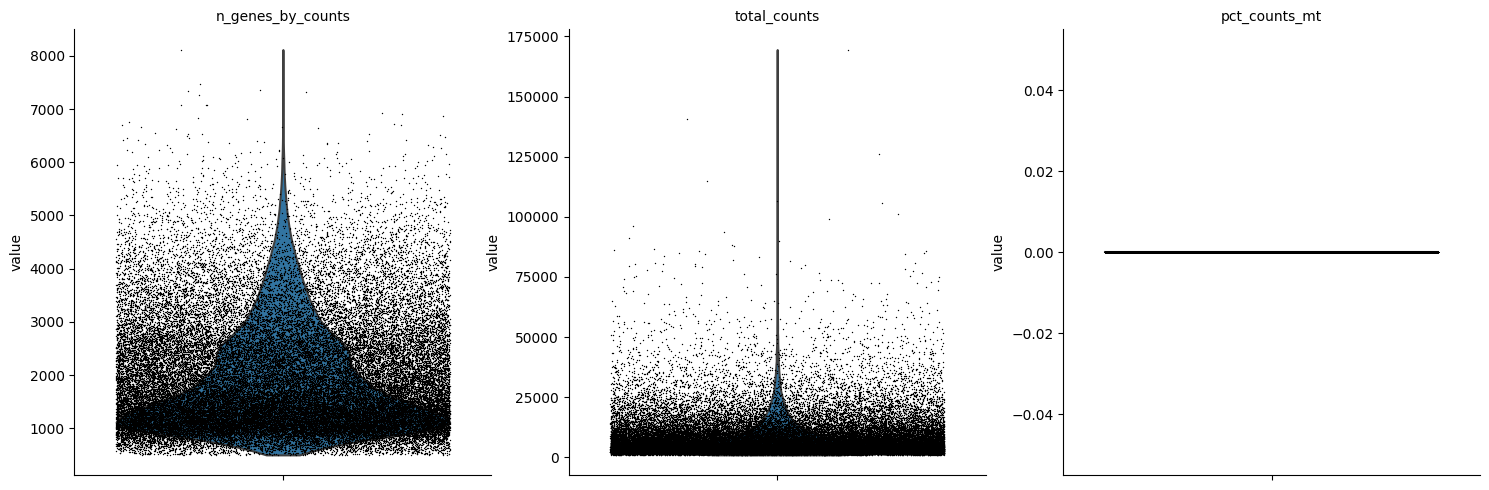

In [68]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

In [69]:
adata = adata[adata.obs[CELL_LABEL] != UNDEFINED, :]
convert_mouse_genes(adata)
# in this case, we filter out duplicated genes directly 
adata = adata[:, ~adata.var["_is_duplicated"]].copy()
print(f"The shape of count matrix: {adata.X.shape}")

For 18228 original genes, 14412 genes are changed to human orthologous genes.
The shape of count matrix: (54865, 17868)


In [70]:
adata.obs[REFERENCE] = (
    "Schaum N, Karkanias J, Neff N F, et al. Single-cell transcriptomics of 20 mouse organs creates " 
    "a Tabula Muris: The Tabula Muris Consortium[J]. Nature, 2018, 562(7727): 367." 
)
adata.obs[SPECIES] = "mouse"
adata.obs[TISSUE] = adata.obs["tissue"].apply(lambda tissue: tissue.lower())
adata.obs[SEQUENCING_METHOD] = "10xGenomics (GemCode Single-Cell 3′ Gel Bead and Library V2 Kit)"
adata.obs = get_target_obs(adata.obs)
adata.obs[ORIGINAL_LABEL] = adata.obs[ORIGINAL_LABEL].astype("str")
adata.obs[CELL_LABEL] = adata.obs[CELL_LABEL].astype("str")
adata.obs

,tissue,annotation,cell_type,reference,species,sequencing_method
10X_P8_13_AAACCTGAGACAAAGG,lung,stromal cell,stromal cell,"Schaum N, Karkanias J, Neff N F, et al. Single...",mouse,10xGenomics (GemCode Single-Cell 3′ Gel Bead a...
10X_P8_13_AAACCTGAGACTAAGT,lung,stromal cell,stromal cell,"Schaum N, Karkanias J, Neff N F, et al. Single...",mouse,10xGenomics (GemCode Single-Cell 3′ Gel Bead a...
10X_P8_13_AAACCTGAGCGTCTAT,lung,stromal cell,stromal cell,"Schaum N, Karkanias J, Neff N F, et al. Single...",mouse,10xGenomics (GemCode Single-Cell 3′ Gel Bead a...
10X_P8_13_AAACCTGAGCTGGAAC,lung,stromal cell,stromal cell,"Schaum N, Karkanias J, Neff N F, et al. Single...",mouse,10xGenomics (GemCode Single-Cell 3′ Gel Bead a...
10X_P8_13_AAACCTGCATCGGTTA,lung,stromal cell,stromal cell,"Schaum N, Karkanias J, Neff N F, et al. Single...",mouse,10xGenomics (GemCode Single-Cell 3′ Gel Bead a...
...,...,...,...,...,...,...
10X_P7_14_TTTGTCAGTAGAGGAA,limb_muscle,mesenchymal stem cell,mesenchymal stem cell,"Schaum N, Karkanias J, Neff N F, et al. Single...",mouse,10xGenomics (GemCode Single-Cell 3′ Gel Bead a...
10X_P7_14_TTTGTCAGTCCTAGCG,limb_muscle,B cell,B cell,"Schaum N, Karkanias J, Neff N F, et al. Single...",mouse,10xGenomics (GemCode Single-Cell 3′ Gel Bead a...
10X_P7_14_TTTGTCATCGGCGGTT,limb_muscle,mesenchymal stem cell,mesenchymal stem cell,"Schaum N, Karkanias J, Neff N F, et al. Single...",mouse,10xGenomics (GemCode Single-Cell 3′ Gel Bead a...
10X_P7_14_TTTGTCATCGGTCCGA,limb_muscle,B cell,B cell,"Schaum N, Karkanias J, Neff N F, et al. Single...",mouse,10xGenomics (GemCode Single-Cell 3′ Gel Bead a...


In [71]:
adata.var

,n_cells,mt,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,_original_symbol,species,_is_duplicated
XKR4,33,False,33,0.000601,99.939852,33,Xkr4,human,False
RP1,33,False,33,0.000784,99.939852,43,Rp1,human,False
SOX17,2019,False,2019,0.121207,96.320058,6650,Sox17,human,False
MRPL15,16169,False,16169,0.473143,70.529481,25959,Mrpl15,human,False
LYPLA1,15115,False,15115,0.421380,72.450560,23119,Lypla1,human,False
...,...,...,...,...,...,...,...,...,...
KDM5D,1085,False,1085,0.020979,98.022419,1151,Kdm5d,human,False
Eif2s3y,7825,False,7825,0.206379,85.737720,11323,Eif2s3y,mouse,False
UTY,844,False,844,0.016003,98.461679,878,Uty,human,False
DDX3Y,10429,False,10429,0.304949,80.991525,16731,Ddx3y,human,False


In [72]:
adata.obs

,tissue,annotation,cell_type,reference,species,sequencing_method
10X_P8_13_AAACCTGAGACAAAGG,lung,stromal cell,stromal cell,"Schaum N, Karkanias J, Neff N F, et al. Single...",mouse,10xGenomics (GemCode Single-Cell 3′ Gel Bead a...
10X_P8_13_AAACCTGAGACTAAGT,lung,stromal cell,stromal cell,"Schaum N, Karkanias J, Neff N F, et al. Single...",mouse,10xGenomics (GemCode Single-Cell 3′ Gel Bead a...
10X_P8_13_AAACCTGAGCGTCTAT,lung,stromal cell,stromal cell,"Schaum N, Karkanias J, Neff N F, et al. Single...",mouse,10xGenomics (GemCode Single-Cell 3′ Gel Bead a...
10X_P8_13_AAACCTGAGCTGGAAC,lung,stromal cell,stromal cell,"Schaum N, Karkanias J, Neff N F, et al. Single...",mouse,10xGenomics (GemCode Single-Cell 3′ Gel Bead a...
10X_P8_13_AAACCTGCATCGGTTA,lung,stromal cell,stromal cell,"Schaum N, Karkanias J, Neff N F, et al. Single...",mouse,10xGenomics (GemCode Single-Cell 3′ Gel Bead a...
...,...,...,...,...,...,...
10X_P7_14_TTTGTCAGTAGAGGAA,limb_muscle,mesenchymal stem cell,mesenchymal stem cell,"Schaum N, Karkanias J, Neff N F, et al. Single...",mouse,10xGenomics (GemCode Single-Cell 3′ Gel Bead a...
10X_P7_14_TTTGTCAGTCCTAGCG,limb_muscle,B cell,B cell,"Schaum N, Karkanias J, Neff N F, et al. Single...",mouse,10xGenomics (GemCode Single-Cell 3′ Gel Bead a...
10X_P7_14_TTTGTCATCGGCGGTT,limb_muscle,mesenchymal stem cell,mesenchymal stem cell,"Schaum N, Karkanias J, Neff N F, et al. Single...",mouse,10xGenomics (GemCode Single-Cell 3′ Gel Bead a...
10X_P7_14_TTTGTCATCGGTCCGA,limb_muscle,B cell,B cell,"Schaum N, Karkanias J, Neff N F, et al. Single...",mouse,10xGenomics (GemCode Single-Cell 3′ Gel Bead a...


In [73]:
selected_tissues = ["spleen", "lung", "tongue", "trachea"]
for tissue in selected_tissues:
    current_adata = adata[adata.obs[TISSUE] == tissue].copy()
    data_dir = os.path.join(CELL_GENERATION_DIR, f"Tabular-Muris-{tissue.title()}")
    if not os.path.exists(data_dir):
        os.mkdir(os.path.join(CELL_GENERATION_DIR, f"Tabular-Muris-{tissue.title()}"))
    current_adata.write_h5ad(os.path.join(data_dir, COUNT_DATA_FILE_NAME))
indices = adata.obs[TISSUE].isin(selected_tissues).values

... storing 'annotation' as categorical
... storing 'cell_type' as categorical
... storing 'reference' as categorical
... storing 'species' as categorical
... storing 'sequencing_method' as categorical
... storing 'species' as categorical
... storing 'annotation' as categorical
... storing 'cell_type' as categorical
... storing 'reference' as categorical
... storing 'species' as categorical
... storing 'sequencing_method' as categorical
... storing 'species' as categorical
... storing 'annotation' as categorical
... storing 'cell_type' as categorical
... storing 'reference' as categorical
... storing 'species' as categorical
... storing 'sequencing_method' as categorical
... storing 'species' as categorical
... storing 'annotation' as categorical
... storing 'cell_type' as categorical
... storing 'reference' as categorical
... storing 'species' as categorical
... storing 'sequencing_method' as categorical
... storing 'species' as categorical


In [74]:
adata_view = adata[indices].copy()
sc.pp.normalize_total(adata_view, target_sum=TOTAL_SUM)
sc.pp.log1p(adata_view, base=BASE)
sc.pp.pca(adata_view)
sc.pp.neighbors(adata_view)
sc.tl.umap(adata_view)

... storing 'annotation' as categorical
... storing 'cell_type' as categorical
... storing 'reference' as categorical
... storing 'species' as categorical
... storing 'sequencing_method' as categorical
... storing 'species' as categorical


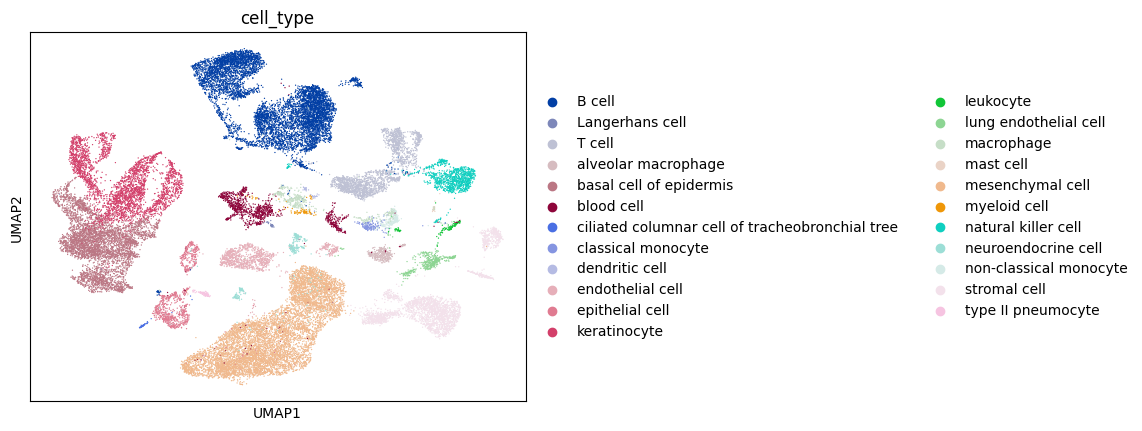

In [75]:
sc.pl.umap(adata_view, color=[CELL_LABEL])

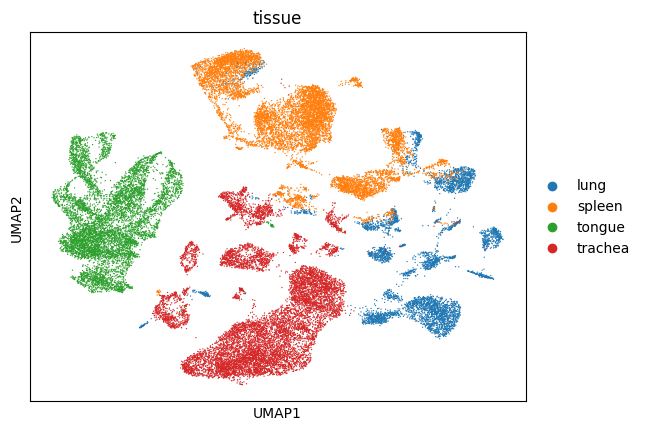

In [76]:
sc.pl.umap(adata_view, color=[TISSUE])